# Fully Supervised DeepLabv3

In [1]:
import sys
import json
import pathlib

In [2]:
def get_root_dir(cwd: pathlib.Path = pathlib.Path().resolve(), anchor="README.md") -> pathlib.Path:
    """
    Get the root directory of the project by searching for a specific anchor file.
    i.e. find the root directory where anchor file README.md/.git is located.

    Args:
        cwd (pathlib.Path): Current working directory.
        anchor (str): The name of the anchor file to search for.

    Returns:
        pathlib.Path: The root directory of the project.

    Raises:
        FileNotFoundError: If the anchor file is not found in any parent directories.
    """
    # Check if the anchor file exists in the current working directory
    # If it does, return the current working directory
    # If it doesn't, check the parent directories until the anchor file is found
    if cwd.joinpath(anchor).exists():
        return cwd
    else:
        for parent in cwd.parents:
            if (parent / anchor).exists():
                return parent

    # If the anchor file is not found in any parent directories, raise an error
    raise FileNotFoundError(f"Anchor file '{anchor}' not found in any parent directories of {cwd}.")

In [3]:
# Git repository information
REPO_GIT_OWNER = "bennylao"
REPO_NAME = "cv-cam-based-img-segmentation"


### Logics to set up paths based on the environment (Google Colab or local machine) ###
COLAB_ROOT_PATH = pathlib.Path("/content")
IS_COLAB = COLAB_ROOT_PATH.exists()

if IS_COLAB:
    # Working on Google Colab
    from google.colab import drive

    # Mount Google Drive
    DRIVE_PATH = COLAB_ROOT_PATH.joinpath("drive")
    drive.flush_and_unmount()
    drive.mount(str(DRIVE_PATH))

    # Load git credentials from Google Drive
    DRIVE_FOLDER_PATH = DRIVE_PATH.joinpath("MyDrive", "Colab Notebooks")
    if DRIVE_FOLDER_PATH.exists():
        with open(DRIVE_FOLDER_PATH.joinpath("git_credentials.json"), "r") as f:
            git_config = json.load(f)
    else:
        raise FileNotFoundError(f"Config file not found at {DRIVE_FOLDER_PATH}")

    # Set up Git credentials
    GIT_USER_NAME = git_config["GIT_USER_NAME"]
    GIT_TOKEN = git_config["GIT_TOKEN"]
    GIT_USER_EMAIL = git_config["GIT_USER_EMAIL"]

    !git config --global user.email {GIT_USER_EMAIL}
    !git config --global user.name {GIT_USER_NAME}

    # Set up project paths
    CURRENT_PATH = pathlib.Path().resolve()
    ROOT = COLAB_ROOT_PATH.joinpath(REPO_NAME)
    DATA_DIR = ROOT.joinpath("data")
    MODEL_DIR = DRIVE_FOLDER_PATH.joinpath("models")
    OUTPUT_DIR = DRIVE_FOLDER_PATH.joinpath("output")

    # Clone repo
    GIT_PATH = f"https://{GIT_TOKEN}@github.com/{REPO_GIT_OWNER}/{REPO_NAME}.git"

    if not ROOT.exists():
        !git clone --depth 1 "{GIT_PATH}" "{ROOT}"

else:
    # Working on local machine
    CURRENT_PATH = pathlib.Path().resolve()
    ROOT = get_root_dir(CURRENT_PATH, anchor="README.md")
    DATA_DIR = ROOT.joinpath("data")
    MODEL_DIR = ROOT.joinpath("models")
    OUTPUT_DIR = ROOT.joinpath("output")

# Create folder if not exist
if not DATA_DIR.exists():
    DATA_DIR.mkdir(parents=True, exist_ok=True)
    print(f"Created data directory at {DATA_DIR}")

if not OUTPUT_DIR.exists():
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    print(f"Created output directory at {OUTPUT_DIR}")

if not MODEL_DIR.exists():
    MODEL_DIR.mkdir(parents=True, exist_ok=True)
    print(f"Created model directory at {MODEL_DIR}")

# Add root path to sys.path
sys.path.append(str(ROOT))

print("=" * 50)
print(f"Runtime: {'Google Colab' if IS_COLAB else 'Local Machine'}")
print(f"{CURRENT_PATH=}")
print(f"{ROOT=}")
print(f"{DATA_DIR=}")
print(f"{MODEL_DIR=}")
print(f"{OUTPUT_DIR=}")
print("=" * 50)

Runtime: Local Machine
CURRENT_PATH=PosixPath('/home/benny/vscode-projects/cv-cam-based-img-segmentation/notebooks')
ROOT=PosixPath('/home/benny/vscode-projects/cv-cam-based-img-segmentation')
DATA_DIR=PosixPath('/home/benny/vscode-projects/cv-cam-based-img-segmentation/data')
MODEL_DIR=PosixPath('/home/benny/vscode-projects/cv-cam-based-img-segmentation/models')
OUTPUT_DIR=PosixPath('/home/benny/vscode-projects/cv-cam-based-img-segmentation/output')


In [4]:
import torch

import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision.models.segmentation import deeplabv3_resnet50
from skimage.segmentation import slic, mark_boundaries
from skimage.morphology import opening, closing, disk
from src import utils

In [5]:
# Set Hyperparameters
IMAGE_SIZE = 256
NUM_CLASSES = 3

TRAIN_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
NUM_WORKERS = 2

# Path to cam dataset
model_name = "cam_deeplab_epoch_5.pth"
CAM_DIR = DATA_DIR.joinpath("cam_dataset")

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pin_memory = True if torch.cuda.is_available() else False
print(f"Using device: {device}")

# Define transforms
train_transforms = utils.Compose([
    utils.PILToTensor(),
    utils.ResizeImgAndMask(size=(IMAGE_SIZE, IMAGE_SIZE)),
    utils.ToDtype(dtype=torch.float32, scale=True),
    utils.FormatCAM(isRaw=False),
])
test_transforms = utils.Compose([
    utils.PILToTensor(),
    utils.ResizeImgAndMask(size=(IMAGE_SIZE, IMAGE_SIZE)),
    utils.ToDtype(dtype=torch.float32, scale=True),
    utils.FormatCAM(isRaw=False),
])
superpixel_transforms = utils.Compose([
	utils.PILToTensor(),
	utils.ResizeImgAndMask(size=(IMAGE_SIZE, IMAGE_SIZE)),
	utils.ToDtype(dtype=torch.float32, scale=True),
])

# Load dataset
trainset, testset = utils.construct_dataset(
    data_dir=DATA_DIR,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    cam_dir=CAM_DIR,
    raw_cam=False,
)
trainloader = DataLoader(
    trainset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=pin_memory,
)
testloader = DataLoader(
    testset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=pin_memory,
)

with open(DATA_DIR / "train_ids.json", "r") as f:
    train_ids = json.load(f)

# Load model
model = deeplabv3_resnet50(weights=None)
model.classifier[4] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
model.load_state_dict(torch.load(MODEL_DIR.joinpath(model_name), weights_only=True))
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(), 
    lr=1e-3,
    weight_decay=1e-4,
)

Using device: cuda


## Train deeplabv3 on the generated CAM masks

In [7]:
def refine_with_soft_voting( # summs probability per class instead of class values + opening and closing smoothing
    image_tensor,
    prob_map,
    n_segments: int = 200,
    compactness: float = 10.0,
    sigma: float = 1.0,
    selem_radius: int = None
):
    """
    Refine a per-pixel probability map by superpixel soft-voting, with smoothing.

    Parameters
    ----------
    image_tensor : torch.Tensor
        Input image in CHW format ([3, H, W]).
    prob_map : np.ndarray
        Softmax output of shape (H, W, C) giving per-pixel class probabilities.
    n_segments : int
        Number of superpixels for SLIC.
    compactness : float
        Compactness parameter for SLIC.
    sigma : float
        Gaussian smoothing parameter for SLIC.
    selem_radius : int or None
        Radius for morphological opening+closing. If None, no smoothing is done.

    Returns
    -------
    smoothed : np.ndarray or None
        If `selem_radius` is given, the result after opening+closing, else None.
    refined : np.ndarray
        Hard labels after superpixel soft-voting, shape (H, W), dtype int.
    superpixels : np.ndarray
        The SLIC label map, shape (H, W), dtype int.
    """
    # Convert image tensor to HWC numpy
    img = image_tensor.permute(1, 2, 0).cpu().numpy()
    prob = prob_map.permute(1, 2, 0).cpu().numpy()  # Convert to HWC

    # 1) Compute superpixels
    superpixels = slic(
        img,
        n_segments=n_segments,
        compactness=compactness,
        sigma=sigma,
        start_label=0
    )
    # print(f"SLIC produced {superpixels.max()+1} superpixels; shape = {superpixels.shape}")

    # 2) Soft‐voting within each superpixel
    H, W, C = prob.shape
    refined = np.zeros((H, W), dtype=np.int32)
    for sp_val in np.unique(superpixels):
        mask = (superpixels == sp_val)
        sp_probs = prob[mask]           # shape: (n_pixels_in_sp, C)
        summed = sp_probs.sum(axis=0)       # shape: (C,)
        refined[mask] = np.argmax(summed)

    # 3) Optional morphological smoothing
    smoothed = None
    if selem_radius is not None:
        selem = disk(selem_radius)
        # Opening then closing to remove small islands & fill gaps
        smooth0 = opening(refined.astype(np.uint8), selem)
        smoothed = closing(smooth0, selem)

    return smoothed, refined, superpixels

(tensor([1, 2, 3]), tensor([36000, 19190, 10346]))


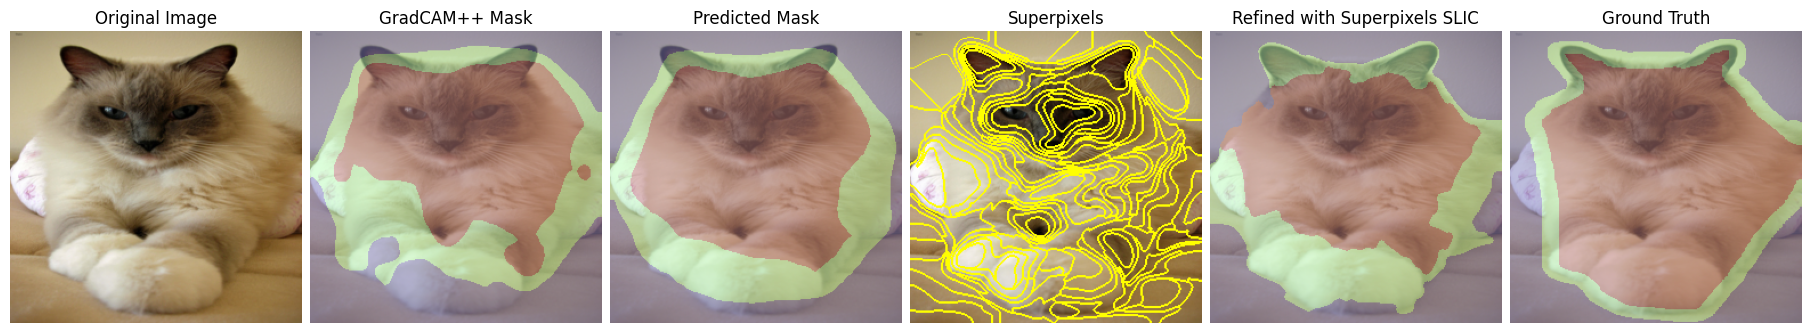

In [8]:
model.eval()

random_index = torch.randint(0, len(trainset), (1,)).item()
images, seg, cam, label = trainloader.dataset[101]
print(torch.unique(seg, return_counts=True))
# Manually map the segmentation labels to 0, 1, 2
# 0: background, 1: ambiguous , 2: object
seg[seg == 2] = 0
seg[seg == 1] = 2
seg[seg == 3] = 1

model.eval()
output = model(images.unsqueeze(0).to(device))['out'].cpu().detach().squeeze(0)

pred = torch.argmax(output, dim=0)

refined, smoothed, superpixels = refine_with_soft_voting(
	images,
	output,
	n_segments=150,
	compactness=0.001,
	sigma=5.0,
	selem_radius=3
)

# --- Visualization (2×3 grid) ---
plt.figure(figsize=(18, 4), layout="constrained")

plt.subplot(1, 6, 1)
plt.imshow(images.permute(1, 2, 0).cpu())
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 6, 2)
plt.imshow(cam.squeeze(0), cmap='jet', alpha=0.5)
plt.imshow(images.permute(1, 2, 0).cpu(), alpha=0.5)
plt.axis('off')
plt.title('GradCAM++ Mask')

plt.subplot(1, 6, 3)
plt.imshow(pred, cmap='jet', alpha=0.5)
plt.imshow(images.permute(1, 2, 0).cpu(), alpha=0.5)
plt.axis('off')
plt.title('Predicted Mask')

plt.subplot(1, 6, 4)
plt.imshow(mark_boundaries(images.permute(1, 2, 0).numpy(), superpixels))
plt.axis('off')
plt.title('Superpixels')

plt.subplot(1, 6, 5)
plt.imshow(refined, cmap='jet', alpha=0.5)
plt.imshow(images.permute(1, 2, 0).cpu(), alpha=0.5)
plt.axis('off')
plt.title('Refined with Superpixels SLIC')

plt.subplot(1, 6, 6)
plt.imshow(seg, cmap='jet', alpha=0.5)
plt.imshow(images.permute(1, 2, 0).cpu(), alpha=0.5)
plt.axis('off')
plt.title('Ground Truth')

plt.show()